In [1]:
%matplotlib inline
import chainer
import matplotlib.pyplot as plt
import net_2
import numpy as np
import os
import chainer.functions as F
from train_vae_with_specified_label import *

In [2]:
# set paths and paramters
out_dir_path = './result'
log_path = os.path.join(out_dir_path, 'log')
model_name = 'model_100.npz'
dimz = 100

In [3]:
# load a model
model = net_2.VAE(784, dimz, 500, F.softplus) 
chainer.serializers.load_npz(os.path.join(out_dir_path, model_name), model, strict=True)
model.to_cpu()

In [4]:
# load dataset
# src_train, src_test = chainer.datasets.get_mnist(withlabel=True) 
# use binarized mnist
TRAIN_PATH = '/root/data/binarized_mnist/train.npy'
TEST_PATH = '/root/data/binarized_mnist/test.npy'
src_train = np.load(TRAIN_PATH)
src_test = np.load(TEST_PATH) 

In [5]:
# extract specified labels
specified_label = 0
train = extract_specified_labels(src_train, specified_label)
test = extract_specified_labels(src_test, specified_label)
print(train.shape)
print(test.shape)

(5923, 784)
(980, 784)


In [6]:
def save_images(x, filename):
    fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi.reshape(28, 28))
    fig.savefig(filename)

In [7]:
# encode and decode training dataset
train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]  
x = chainer.Variable(np.asarray(train[train_ind])) 
with chainer.using_config('train', False), chainer.no_backprop_mode(): 
    x1 = model(x) 

train


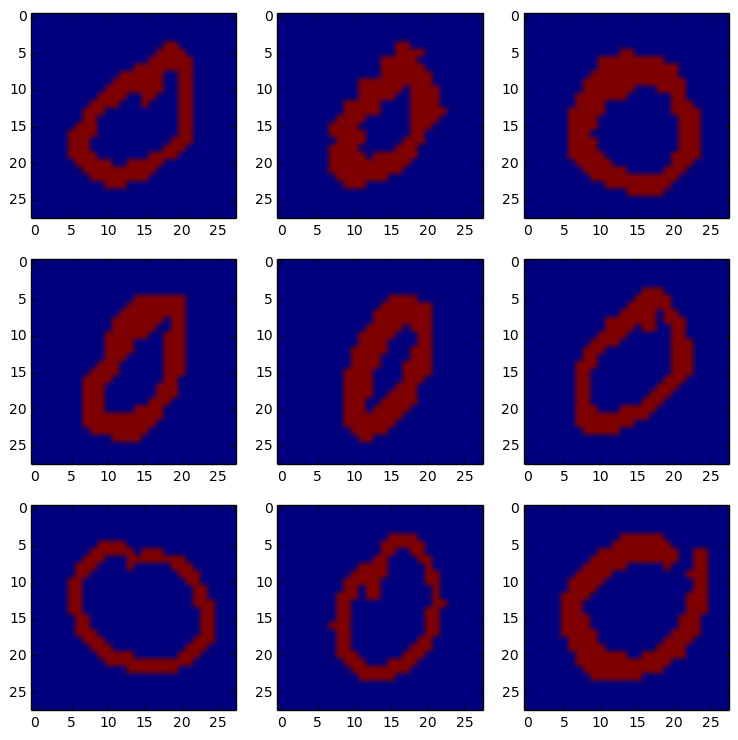

In [8]:
# display and save images
print('train')
save_images(x.data, os.path.join(out_dir_path, 'train')) 

train_reconstructed


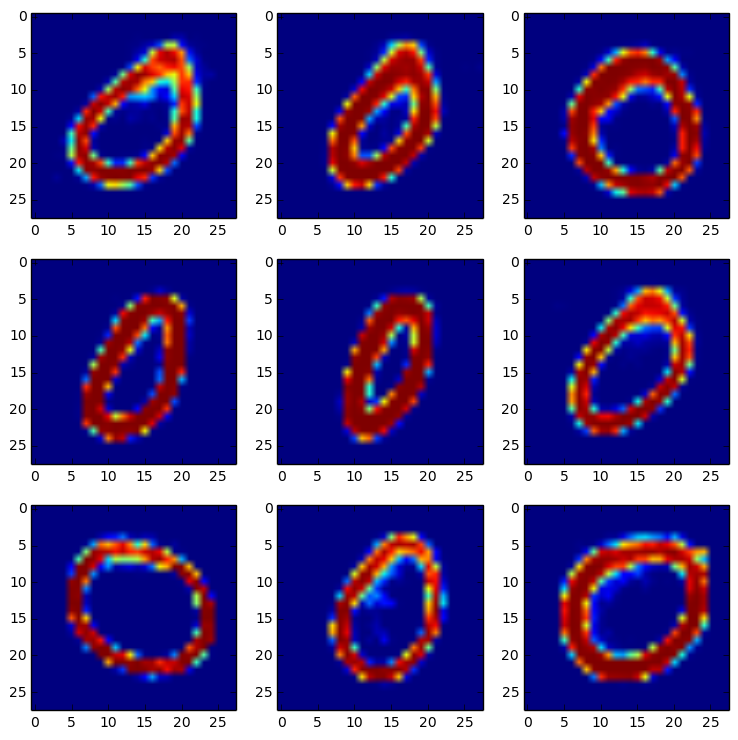

In [9]:
print('train_reconstructed')
save_images(x1.data, os.path.join(out_dir_path, 'train_reconstructed'))  

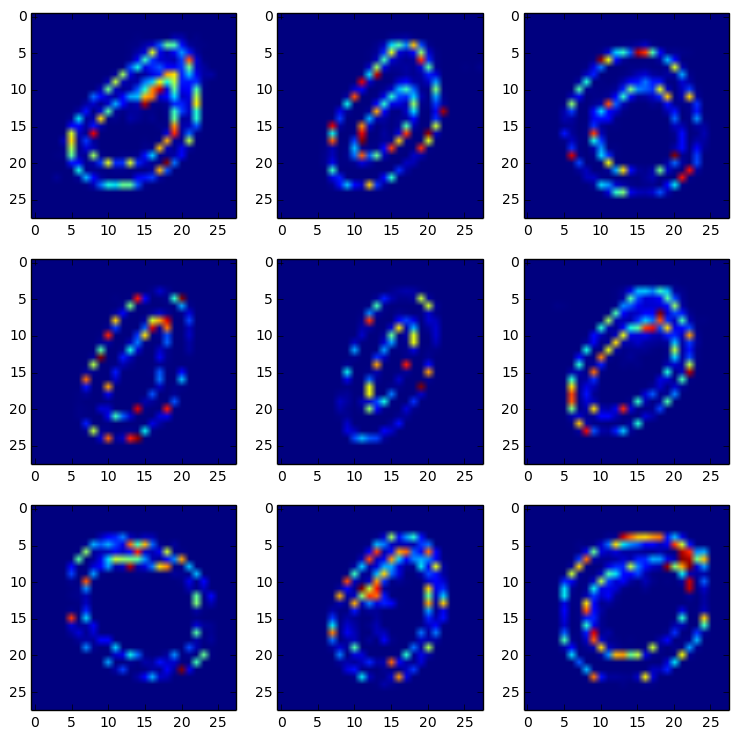

In [10]:
# see difference between them
dx = np.abs(x.data - x1.data)
save_images(dx, os.path.join(out_dir_path, 'train_diff')) 

In [11]:
# encode and decode test dataset
test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
x = chainer.Variable(np.asarray(test[test_ind]))
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)

test


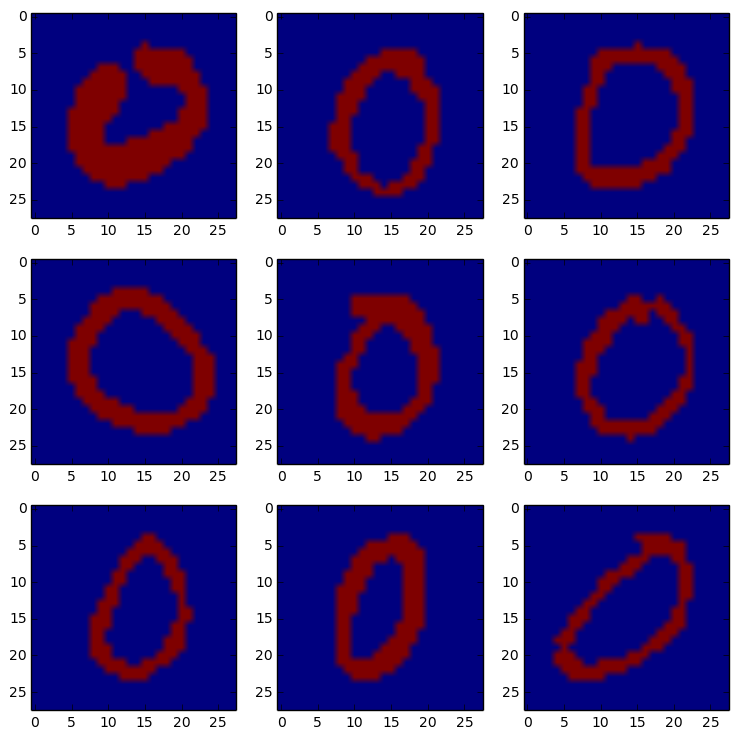

In [12]:
print('test')    
save_images(x.data, os.path.join(out_dir_path, 'test'))

test reconstructed


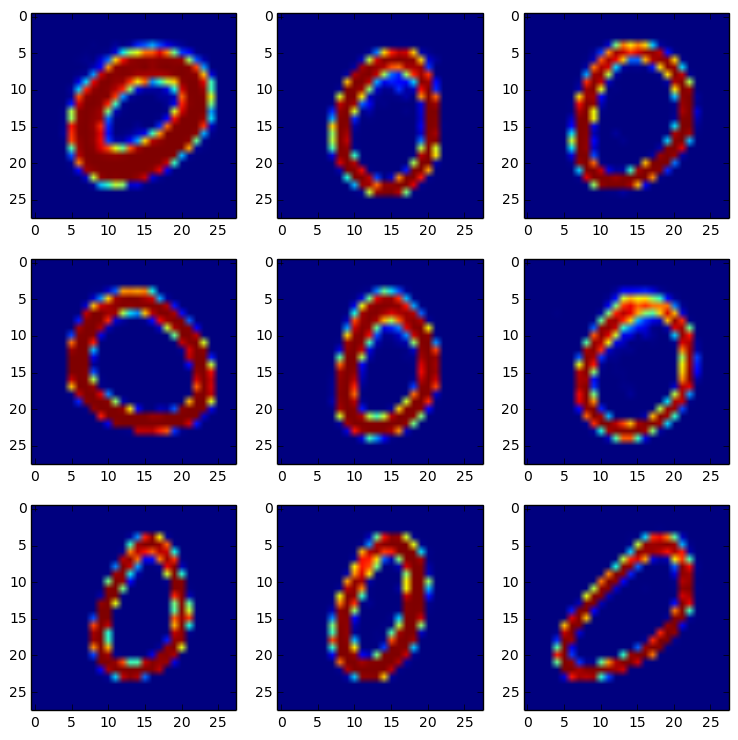

In [13]:
print('test reconstructed')
save_images(x1.data, os.path.join(out_dir_path, 'test_reconstructed'))

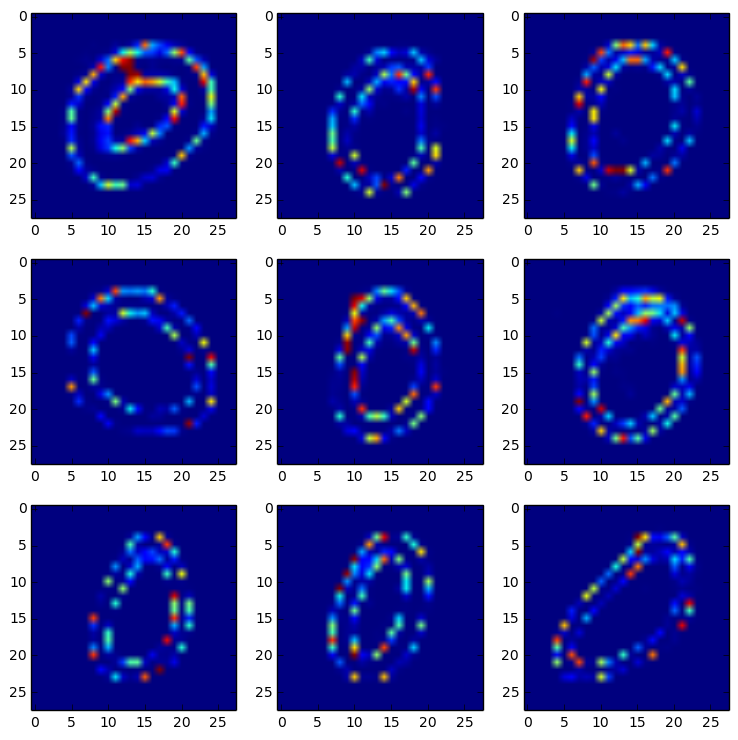

In [14]:
# see difference between them
dx = np.abs(x.data - x1.data)
save_images(dx, os.path.join(out_dir_path, 'test_diff')) 

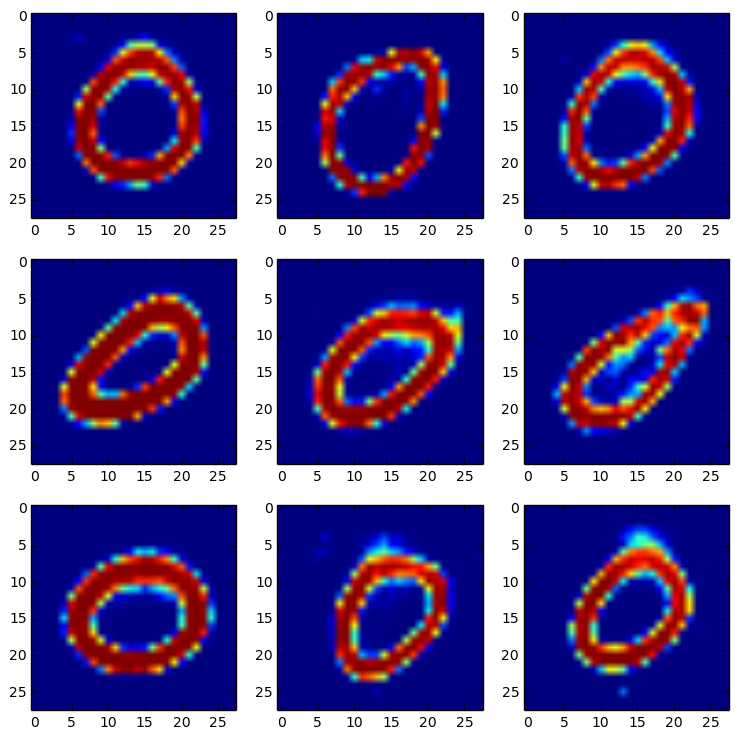

In [15]:
# draw images from randomly sampled z
np.random.seed(1234)
z = chainer.Variable(
    np.random.normal(0, 1, (9, dimz)).astype(np.float32))
x = model.decode(z)
save_images(x.data, os.path.join(out_dir_path, 'sampled'))

In [16]:
def load_loss(path):
    return [float(line) for line in open(path)]

import re
def loss_generator(path, s):
    s = re.compile(r'"{}": (-?[0-9]+.[0-9]+),?'.format(s))
    for line in open(path):
        m = s.findall(line)
        if m:
            yield float(m[0])

In [17]:
# extract information from log
main_loss = list(loss_generator(log_path, 'main/loss'))
validation_main_loss = list(loss_generator(log_path, 'validation/main/loss'))
main_mu = list(loss_generator(log_path, 'main/mu'))
validation_main_mu = list(loss_generator(log_path, 'validation/main/mu'))
main_sigma = list(loss_generator(log_path, 'main/sigma'))
validation_main_sigma = list(loss_generator(log_path, 'validation/main/sigma'))

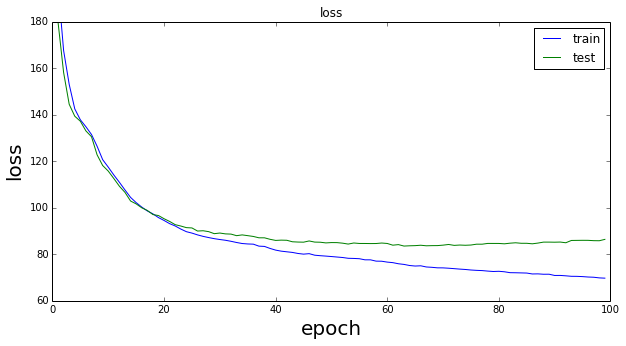

In [18]:
# display loss
plt.figure(figsize=(10, 5))
plt.title('loss')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.xlim(0, 100)
plt.ylim(60, 180)
plt.plot(main_loss, label='train')
plt.plot(validation_main_loss, label='test')
plt.legend(loc='best')
plt.show()

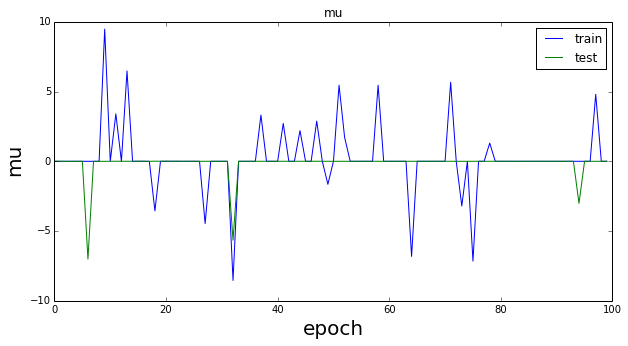

In [19]:
# display mu
plt.figure(figsize=(10, 5))
plt.title('mu')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('mu', fontsize=20)
plt.xlim(0, 100)
# plt.ylim(-0.01, 0.01)
plt.plot(main_mu, label='train')
plt.plot(validation_main_mu, label='test')
plt.legend(loc='best')
plt.show()

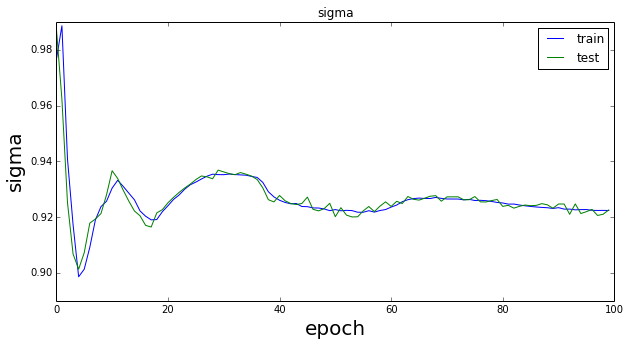

In [20]:
# display sigma
plt.figure(figsize=(10, 5))
plt.title('sigma')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('sigma', fontsize=20)
plt.xlim(0, 100)
# plt.ylim(8, 22)
plt.plot(main_sigma, label='train')
plt.plot(validation_main_sigma, label='test')
plt.legend(loc='best')
plt.show()

In [21]:
def decode(dataset):
    ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]  
    x = chainer.Variable(np.asarray(dataset[ind])) 
    with chainer.using_config('train', False), chainer.no_backprop_mode(): 
        mu, ln_var = model.encode(x) 
        average_mu = np.mean(mu.data)
        sigma = np.exp(ln_var.data/2)
        average_sigma = np.mean(sigma)
        return average_mu, average_sigma

In [22]:
# average mu and sigma for training data
mu, sigma = decode(train)
print('mu(0): {}'.format(mu))
print('sigma(1): {}'.format(sigma))

mu(0): 0.03299320116639137
sigma(1): 0.9216595888137817


In [23]:
# average mu and sigma for test data
mu, sigma = decode(test)
print('mu(0): {}'.format(mu))
print('sigma(1): {}'.format(sigma))

mu(0): 0.017021380364894867
sigma(1): 0.924589991569519


# 画像の符号化

In [24]:
# select 1,000 images with label zero, which are considered as normal images
zero_number = 1000
zeros = train[:zero_number]
zeros.shape

(1000, 784)

In [25]:
# encode them
xs = chainer.Variable(zeros) 
with chainer.using_config('train', False), chainer.no_backprop_mode(): 
    zero_mus, zero_ln_vars = model.encode(xs) 

In [26]:
# select 100 images with label six, which are considered as anormaly images
anomaly_label = 6
sixs = extract_specified_labels(src_train, anomaly_label)[:100]
sixs.shape

(100, 784)

In [27]:
# encode them
xs = chainer.Variable(sixs) 
with chainer.using_config('train', False), chainer.no_backprop_mode(): 
    six_mus, six_ln_vars = model.encode(xs) 

In [28]:
# concatenate normal and anormaly mus
dataset = np.concatenate([zero_mus.data, six_mus.data], axis=0)
print(dataset.shape)

(1100, 100)


In [29]:
from sklearn.manifold import TSNE

In [30]:
# reduce dimensions
reduced_dataset = TSNE(n_components=2, random_state=0).fit_transform(dataset)
# reduced_dataset = dataset.copy()

In [31]:
reduced_dataset.shape

(1100, 2)

In [32]:
# split data into normal and anormaly data
zero_reduced_dataset = reduced_dataset[:zero_number]
six_reduced_dataset = reduced_dataset[zero_number:]
zero_reduced_dataset.shape

(1000, 2)

In [33]:
# calculate mahalanobis distance
from scipy.spatial.distance import mahalanobis

# calculate covariance matrix for training data
sigma = np.cov(zero_reduced_dataset, rowvar=False)

# make inverse of it
inv_sigma = np.linalg.inv(np.cov(zero_reduced_dataset, rowvar=False)) 

# calculate mean for training data
mean = np.mean(zero_reduced_dataset, axis=0)

# calculate mahalanobis distances
outlier_dists = [mahalanobis(mean, outlier, inv_sigma) for outlier in six_reduced_dataset]
inlier_dists = [mahalanobis(mean, inlier, inv_sigma) for inlier in zero_reduced_dataset]

average_outlier_dist = np.mean(outlier_dists)
average_inlier_dist = np.mean(inlier_dists)
print('average_outlier_dist', average_outlier_dist)
print('average_inlier_dist', average_inlier_dist)
print(sigma)

average_outlier_dist 3.16682474145
average_inlier_dist 1.30856680297
[[ 226.96707771   14.19119611]
 [  14.19119611  311.37565287]]


/usr/local/lib/python3.4/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.4/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'fa

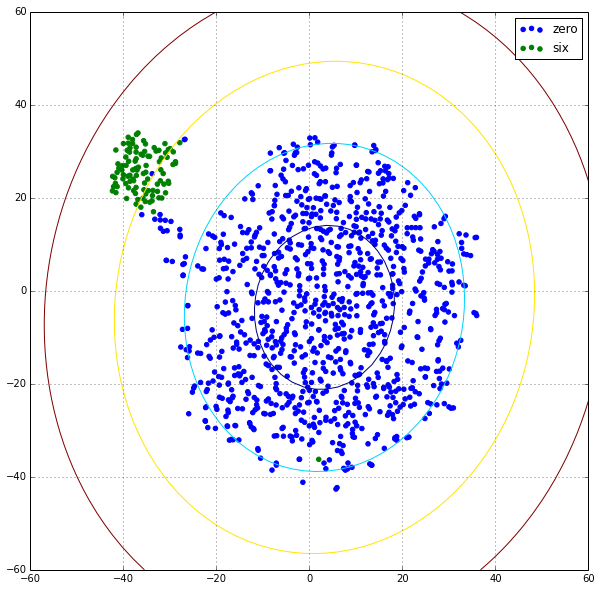

In [34]:
# display 
plt.figure(figsize=(10, 10))
plt.scatter(reduced_dataset[:zero_number, 0], reduced_dataset[:zero_number, 1], c='blue', edgecolors='blue', label='zero', marker='o')
plt.scatter(reduced_dataset[zero_number:, 0], reduced_dataset[zero_number:, 1], c='green', edgecolors='green', label='six', marker='o')
plt.axis('equal')


n = 100
x = np.linspace(-60, 60)
y = np.linspace(-60, 60)
X, Y = np.meshgrid(x, y)
Z = np.empty((n//2, n//2))
for r  in range(n // 2):
    for c in range(n // 2):
        v = np.c_[X[r, c], Y[r, c]]
        Z[r, c] = mahalanobis(mean, v, inv_sigma)

plt.contour(X, Y, np.array(Z), levels=[1, 2, 3, 4])

plt.xlim(-60, 60)
plt.ylim(-60, 60)

plt.grid(True)
plt.legend(loc='best')
plt.show()

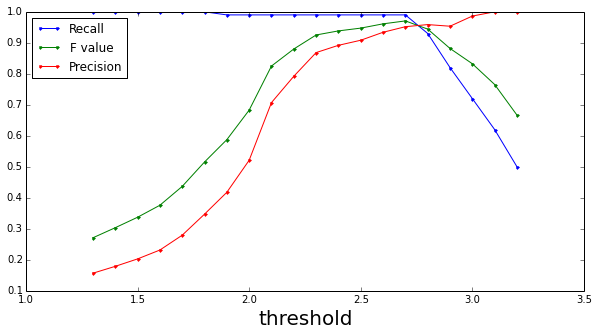

In [40]:
# display F values
plt.figure(figsize=(10, 5))
thrs = []
fs = []
prs = []
res = []
with open('./f_value.txt') as fin:
    for line in fin:
        thr, f, pr, re = [float(item) for item in line.strip().split()]
        thrs.append(thr)
        fs.append(f)
        prs.append(pr)
        res.append(re)
plt.xlabel('threshold', fontsize=20)
plt.plot(thrs, res, marker='.', label='Recall')
plt.plot(thrs, fs, marker='.', label='F value')
plt.plot(thrs, prs, marker='.', label='Precision')
plt.legend(loc='best')
plt.show()

# 画像の符号化・復号化

In [36]:
anomaly_label = 6
random_sixs = extract_specified_labels(src_train, anomaly_label)[:9]
random_sixs.shape

(9, 784)

In [37]:
x = chainer.Variable(random_sixs)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)

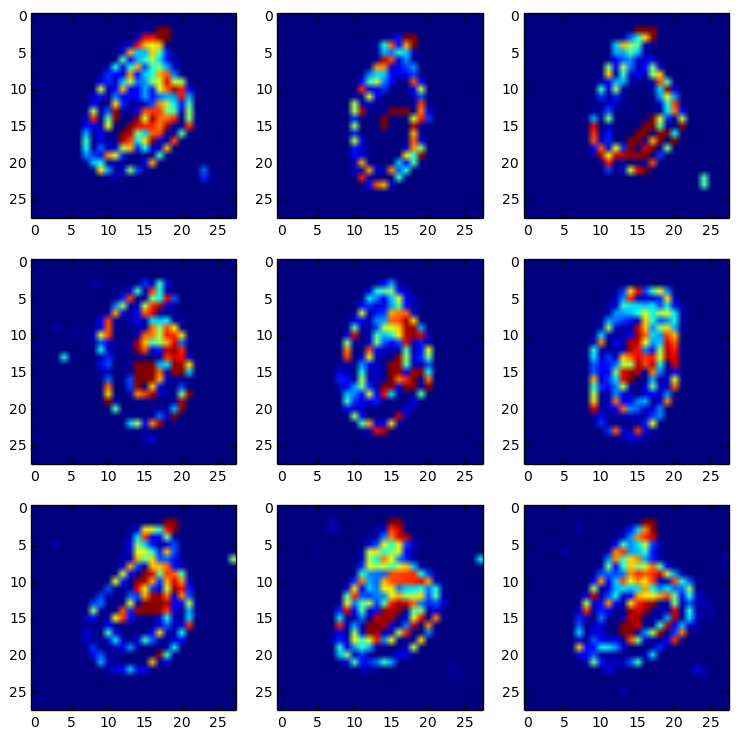

In [38]:
# 差をとる。
dx = np.abs(x.data - x1.data)
save_images(dx, os.path.join(out_dir_path, 'six_diff')) 